In [126]:
from glob import glob
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [162]:

class CorrelationTables:
    def __init__(self):
        print('Please add data primitives in format of data path')
        self.primitives_list = list()
        self.correlation_results = list()

    def add_research_primitive(self, primitive_path, index_col=0, data_freq='1T'):
        primitive_name = primitive_path.split('/')[-1].split('.')[0]
        primitive_data = pd.read_csv(primitive_path, index_col=index_col)
        primitive_data.index = pd.to_datetime(primitive_data.index)
        print(f'====    Added {primitive_name}  ====')
        self.primitives_list.append({"Primitive_name": primitive_name, "Primitive_content": primitive_data, "Primitive_volume": primitive_data.shape[0],
                                     "Primitive_Frequency": data_freq})
        del primitive_name
        del primitive_data

    def make_correlation_table(self, table_data_slices, show_logs=False):
        print('=' * 10)
        print('Be careful. In one correlation table can be only dataframes with similar shapes')
        #TODO Need to make method to guarantee sync records from datetimes
        unique_shapes = np.unique(np.array([primitive["Primitive_volume"] for primitive in self.primitives_list]))
        for similar_shapes in unique_shapes:
            buffer_primitives = list(filter(lambda primitive: primitive["Primitive_volume"] == similar_shapes, self.primitives_list))

            if len(buffer_primitives) >= 2:
                res = self._complete_correlation(buffer_primitives, year_of_correlation=table_data_slices, log_show=show_logs)
                self.correlation_results.append(res)
            else:
                print(f"Cannot find a pair (similar shape) to {[primitive['Primitive_name'] for primitive in buffer_primitives]}. Shape={similar_shapes}")
                continue

    def _complete_correlation(self, similar_primitives, year_of_correlation, log_show=True):
        print('=' * 10)
        correlation_dict = {'Primitives_list': [primitive['Primitive_name'] for primitive in similar_primitives], 'Shape': similar_primitives[0]["Primitive_volume"]}
        if log_show:
            print('-' * 5 + '   EXTEND_INFO    ' + '-' * 5)
            print('Primitives total:', len(similar_primitives))
            print('Primitives objects:', [primitive['Primitive_name'] for primitive in similar_primitives])
            print('Primitives shape:', similar_primitives[0]["Primitive_volume"])
            print('-' * 5 + '   END_EXTEND_INFO    ' + '-' * 5)

        results = list()
        for borders in year_of_correlation:
            extend_info=False
            if log_show:
                extend_info = True
                print("Current Borders:", borders)

            work_primitives = [{"Primitive_name": primitive["Primitive_name"],"Primitive_content": primitive["Primitive_content"].loc[borders[0]: borders[1]], "Primitive_Freq": primitive["Primitive_Frequency"]} for primitive in similar_primitives]

            carretes, corrs =  self._calculate_correlation(work_primitives, extend_info=extend_info, borders=borders)
            results.append({"borders": borders, "timesum": carretes, "corr_tables": corrs})
        correlation_dict['results'] = results
        return correlation_dict


    def _calculate_correlation(self, primitives, borders, list_return_summary=['5T', '30T', '1H', '6H', '1D'],extend_info=True):
        return_correlations = list()
        logged_primitives = [[primitive["Primitive_name"], np.log(primitive["Primitive_content"].open).diff()[1:].resample(primitive["Primitive_Freq"]).first()] for primitive in primitives]
        WIDTH_CONST = 2 * len(primitives)
        fig, ax = plt.subplots(1, len(list_return_summary), figsize=(len(list_return_summary) * WIDTH_CONST ,WIDTH_CONST))
        fig.suptitle(f"{datetime.date.strftime(borders[0], '%Y-%m')}:{datetime.date.strftime(borders[1], '%Y-%m')}")
        for number, research_carret in enumerate(list_return_summary):
            if extend_info:
                print('Current Research Resample:', research_carret)

            corr_df = pd.DataFrame()
            resampled_primitives = [[primitive[0], primitive[1].resample(research_carret).sum()] for primitive in logged_primitives]
            for obj in resampled_primitives:
                corr_df[f"{obj[0]}"] = obj[1]
            correlation = corr_df.corr()
            sns.heatmap(correlation, ax=ax[number], annot=True, fmt=".2g")
            ax[number].title.set_text(f"{research_carret}")

            return_correlations.append(correlation)
        return list_return_summary, return_correlations

        pass

Please add data primitives in format of data path
====    Added AUDCAD  ====
====    Added EURUSD  ====
====    Added USDCHF  ====
Be careful. In one correlation table can be only dataframes with similar shapes


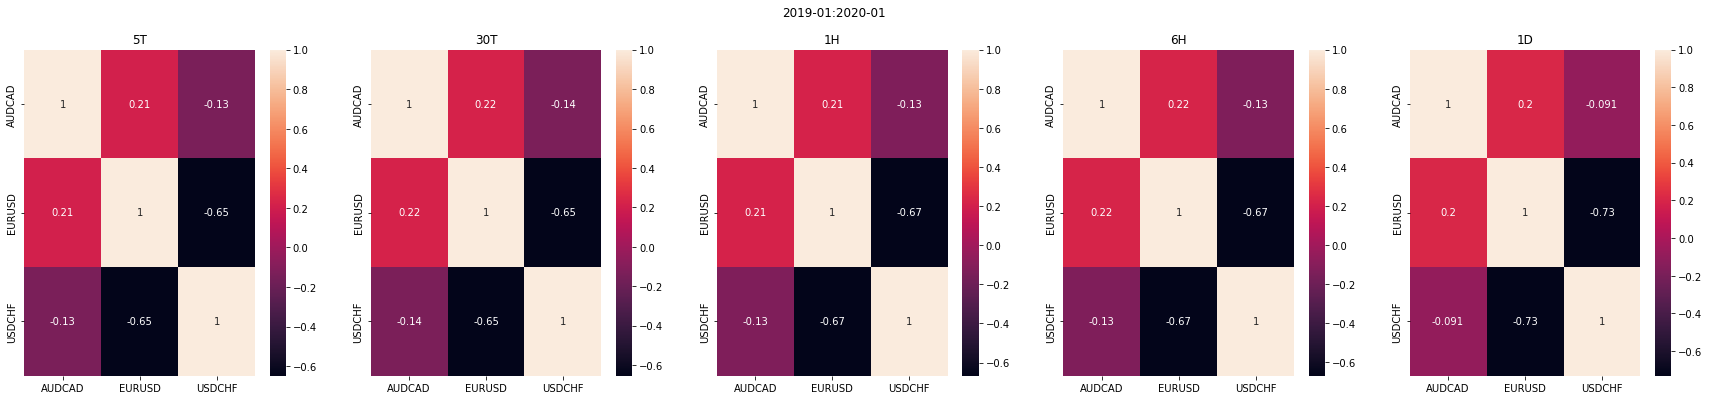

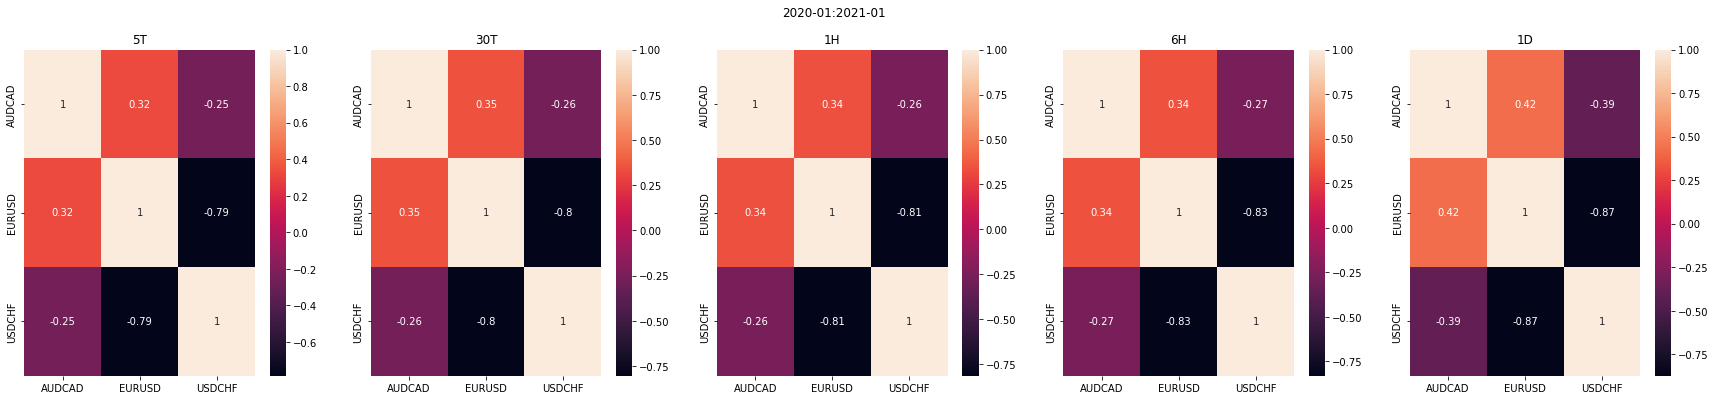

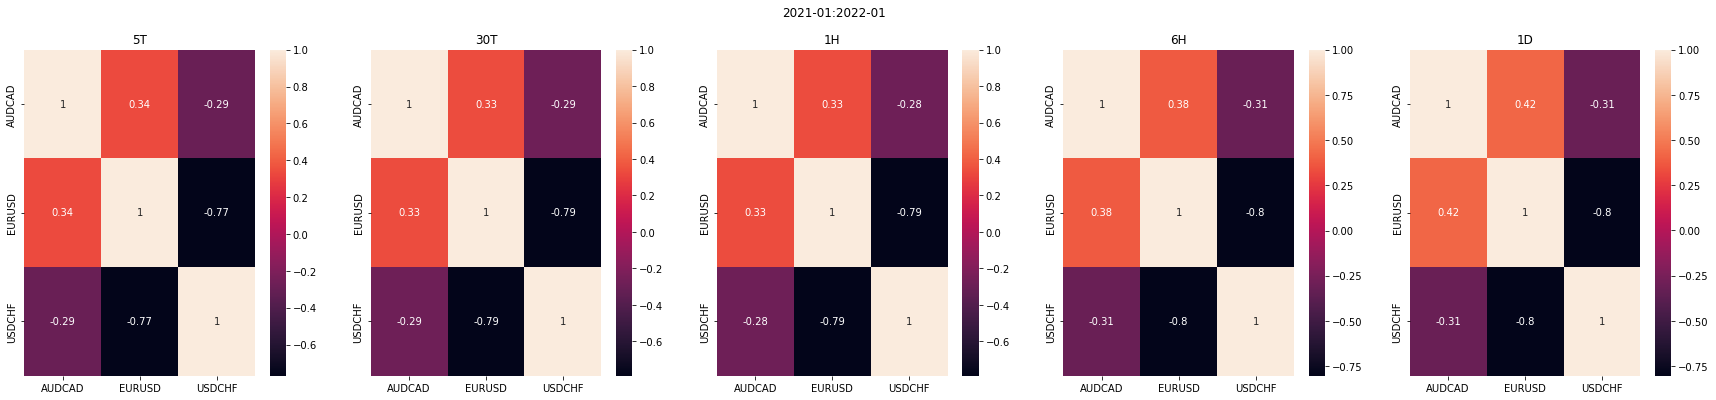

In [163]:
years = [2019, 2020, 2021]
#years = [2019]
borders_list = [[datetime.datetime(year=x, month=1, day=1), datetime.datetime(year=x+1, month=1, day=1)] for x in years]
data_path = glob('zip_data/*.csv')[:3]
TestCorr = CorrelationTables()
for _ in data_path:
    TestCorr.add_research_primitive(_)

TestCorr.make_correlation_table(table_data_slices=borders_list, show_logs=False)

In [182]:
i = 0
buff = TestCorr.correlation_results[i]
a = buff["results"][0]
a


{'borders': [datetime.datetime(2019, 1, 1, 0, 0),
  datetime.datetime(2020, 1, 1, 0, 0)],
 'timesum': ['5T', '30T', '1H', '6H', '1D'],
 'corr_tables': [          AUDCAD    EURUSD    USDCHF
  AUDCAD  1.000000  0.212305 -0.134066
  EURUSD  0.212305  1.000000 -0.648539
  USDCHF -0.134066 -0.648539  1.000000,
            AUDCAD    EURUSD    USDCHF
  AUDCAD  1.000000  0.219099 -0.135916
  EURUSD  0.219099  1.000000 -0.654059
  USDCHF -0.135916 -0.654059  1.000000,
            AUDCAD    EURUSD    USDCHF
  AUDCAD  1.000000  0.214474 -0.130901
  EURUSD  0.214474  1.000000 -0.667632
  USDCHF -0.130901 -0.667632  1.000000,
            AUDCAD    EURUSD    USDCHF
  AUDCAD  1.000000  0.221794 -0.128205
  EURUSD  0.221794  1.000000 -0.668317
  USDCHF -0.128205 -0.668317  1.000000,
            AUDCAD    EURUSD    USDCHF
  AUDCAD  1.000000  0.203350 -0.091046
  EURUSD  0.203350  1.000000 -0.730556
  USDCHF -0.091046 -0.730556  1.000000]}

[[[datetime.datetime(2019, 1, 1, 0, 0), datetime.datetime(2020, 1, 1, 0, 0)], [('5T',           AUDCAD    EURUSD    USDCHF
AUDCAD  1.000000  0.212305 -0.134066
EURUSD  0.212305  1.000000 -0.648539
USDCHF -0.134066 -0.648539  1.000000)]]]
[[[datetime.datetime(2019, 1, 1, 0, 0), datetime.datetime(2020, 1, 1, 0, 0)], [('5T',           AUDCAD    EURUSD    USDCHF
AUDCAD  1.000000  0.212305 -0.134066
EURUSD  0.212305  1.000000 -0.648539
USDCHF -0.134066 -0.648539  1.000000)]], [[datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2021, 1, 1, 0, 0)], [('5T',           AUDCAD    EURUSD    USDCHF
AUDCAD  1.000000  0.324518 -0.251079
EURUSD  0.324518  1.000000 -0.785410
USDCHF -0.251079 -0.785410  1.000000)]]]
[[[datetime.datetime(2019, 1, 1, 0, 0), datetime.datetime(2020, 1, 1, 0, 0)], [('5T',           AUDCAD    EURUSD    USDCHF
AUDCAD  1.000000  0.212305 -0.134066
EURUSD  0.212305  1.000000 -0.648539
USDCHF -0.134066 -0.648539  1.000000)]], [[datetime.datetime(2020, 1, 1, 0, 0), datetime.d

[[[datetime.datetime(2019, 1, 1, 0, 0), datetime.datetime(2020, 1, 1, 0, 0)],
  [('5T',
              AUDCAD    EURUSD    USDCHF
    AUDCAD  1.000000  0.212305 -0.134066
    EURUSD  0.212305  1.000000 -0.648539
    USDCHF -0.134066 -0.648539  1.000000)]],
 [[datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2021, 1, 1, 0, 0)],
  [('5T',
              AUDCAD    EURUSD    USDCHF
    AUDCAD  1.000000  0.324518 -0.251079
    EURUSD  0.324518  1.000000 -0.785410
    USDCHF -0.251079 -0.785410  1.000000)]],
 [[datetime.datetime(2021, 1, 1, 0, 0), datetime.datetime(2022, 1, 1, 0, 0)],
  [('5T',
              AUDCAD    EURUSD    USDCHF
    AUDCAD  1.000000  0.335491 -0.285555
    EURUSD  0.335491  1.000000 -0.769185
    USDCHF -0.285555 -0.769185  1.000000)]],
 [[datetime.datetime(2019, 1, 1, 0, 0), datetime.datetime(2020, 1, 1, 0, 0)],
  [('30T',
              AUDCAD    EURUSD    USDCHF
    AUDCAD  1.000000  0.219099 -0.135916
    EURUSD  0.219099  1.000000 -0.654059
    USDCHF -0.135916

In [196]:
for _ in normalized_dicts[:]:
    print(_)

[[[datetime.datetime(2019, 1, 1, 0, 0), datetime.datetime(2020, 1, 1, 0, 0)], [('5T',           AUDCAD    EURUSD    USDCHF
AUDCAD  1.000000  0.212305 -0.134066
EURUSD  0.212305  1.000000 -0.648539
USDCHF -0.134066 -0.648539  1.000000)]]]
[[[datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2021, 1, 1, 0, 0)], [('5T',           AUDCAD    EURUSD    USDCHF
AUDCAD  1.000000  0.324518 -0.251079
EURUSD  0.324518  1.000000 -0.785410
USDCHF -0.251079 -0.785410  1.000000)]]]
